### Modify the file path according to your environment

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'CV_HW3/assignment3/'
FOLDERNAME = "ComputerVision/HW3"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/{}'.format(FOLDERNAME))

# This downloads the COCO dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/CV/datasets
!bash get_datasets.sh

%cd /content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/CV/datasets
/content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3


# Image Captioning with RNNs
In this exercise, you will implement vanilla Recurrent Neural Networks and use them to train a model that can generate novel captions for images.


In [2]:
# Setup cell.
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./CV')

from CV.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from CV.rnn_layers import *
from CV.captioning_solver import CaptioningSolver
from CV.classifiers.rnn import CaptioningRNN
from CV.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from CV.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# COCO Dataset
For this exercise, we will use the 2014 release of the [COCO dataset](https://cocodataset.org/), a standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

**Image features.** We have preprocessed the data and extracted features for you already. For all images, we have extracted features from the fc7 layer of the VGG-16 network pretrained on ImageNet, and these features are stored in the files `train2014_vgg16_fc7.h5` and `val2014_vgg16_fc7.h5`. To cut down on processing time and memory requirements, we have reduced the dimensionality of the features from 4096 to 512 using Principal Component Analysis (PCA), and these features are stored in the files `train2014_vgg16_fc7_pca.h5` and `val2014_vgg16_fc7_pca.h5`. The raw images take up nearly 20GB of space so we have not included them in the download. Since all images are taken from Flickr, we have stored the URLs of the training and validation images in the files `train2014_urls.txt` and `val2014_urls.txt`. This allows you to download images on-the-fly for visualization.

**Captions.** Dealing with strings is inefficient, so we will work with an encoded version of the captions. Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is in the file `coco2014_vocab.json`, and you can use the function `decode_captions` from the file `CV/coco_utils.py` to convert NumPy arrays of integer IDs back into strings.

**Tokens.** There are a couple special tokens that we add to the vocabulary, and we have taken care of all implementation details around special tokens for you. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens.

You can load all of the COCO data (captions, features, URLs, and vocabulary) using the `load_coco_data` function from the file `CV/coco_utils.py`. Run the following cell to do so:

In [3]:
# Load COCO data from disk into a dictionary.
# We'll work with dimensionality-reduced features for the remainder of this assignment,
# but you can also experiment with the original features on your own by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary.
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  /content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/CV/datasets/coco_captioning
train_captions <class 'numpy.ndarray'> (376490, 17) int32
train_image_idxs <class 'numpy.ndarray'> (376490,) int32
val_captions <class 'numpy.ndarray'> (184296, 17) int32
val_image_idxs <class 'numpy.ndarray'> (184296,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 50261
word_to_idx <class 'dict'> 50261
train_urls <class 'numpy.ndarray'> (82783,) <U71
val_urls <class 'numpy.ndarray'> (40504,) <U67
nice_feature <class 'numpy.ndarray'> (1000, 4096) float32


## Inspect the Data
It is always a good idea to look at examples from the dataset before working with it.

You can use the `sample_coco_minibatch` function from the file `CV/coco_utils.py` to sample minibatches of data from the data structure returned from `load_coco_data`. Run the following to sample a small minibatch of training data and show the images and their captions. Running it multiple times and looking at the results helps you to get a sense of the dataset.

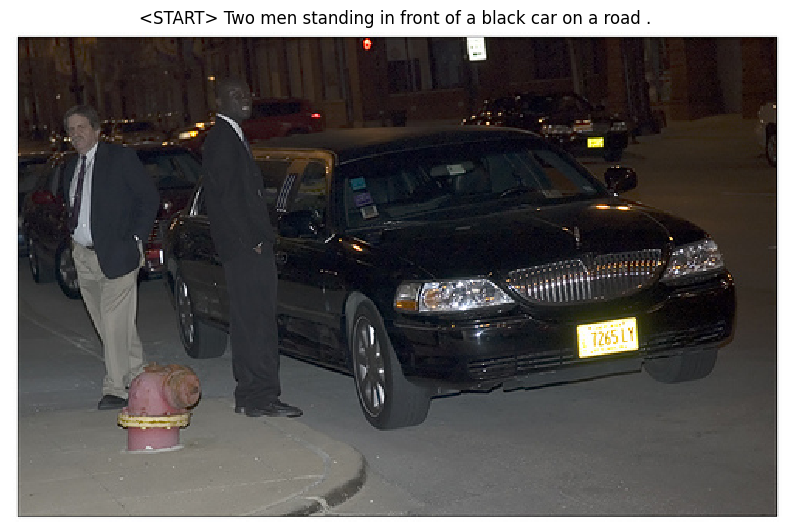

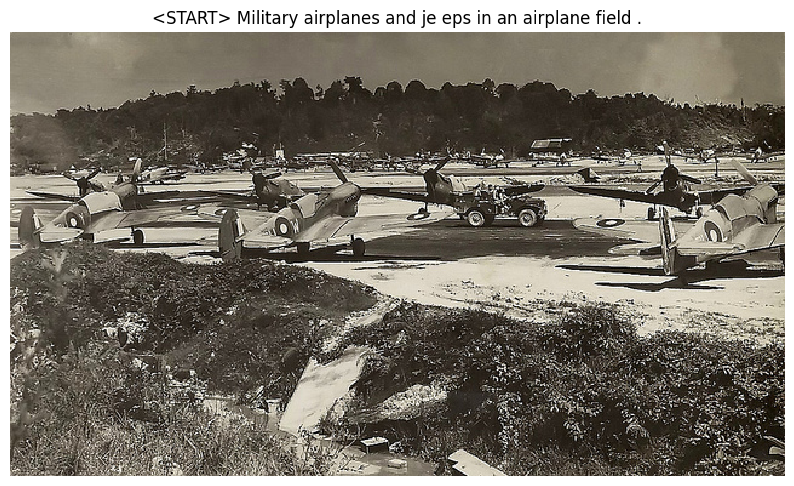

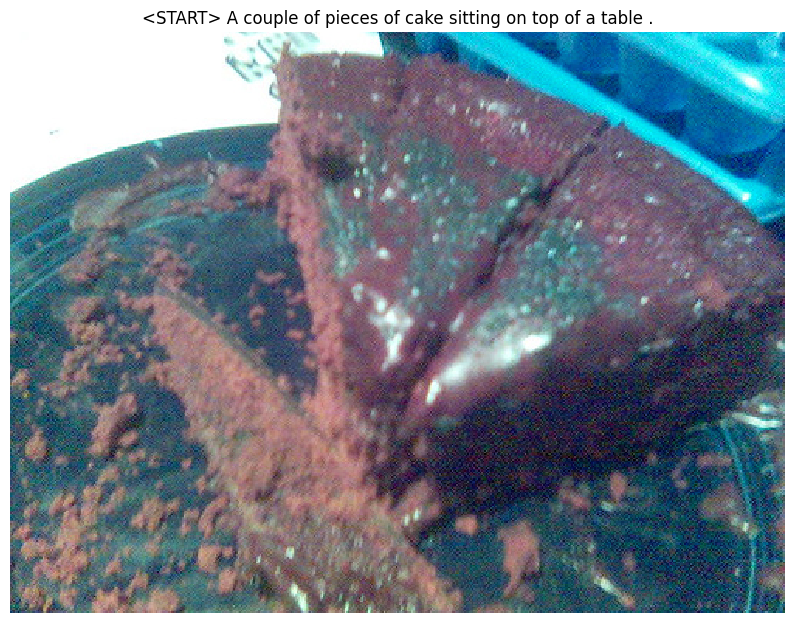

In [4]:
# Sample a minibatch and show the images and captions.
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
batch_size = 3

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

# Recurrent Neural Network
We will use Recurrent Neural Network (RNN) language models for image captioning. The file `CV/rnn_layers.py` contains implementations of different layer types that are needed for recurrent neural networks, and the file `CV/classifiers/rnn.py` uses these layers to implement an image captioning model.

We will first implement different types of RNN layers in `CV/rnn_layers.py`.

**NOTE:** The Long-Short Term Memory (LSTM) RNN is a common variant of the vanilla RNN. `LSTM_Captioning.ipynb` is optional extra credit, so don't worry about references to LSTM in `CV/classifiers/rnn.py` and `CV/rnn_layers.py` for now.

# Vanilla RNN: Step Forward
Open the file `CV/rnn_layers.py`. This file implements the forward and backward passes for different types of layers that are commonly used in recurrent neural networks.

First implement the function `rnn_step_forward` which implements the forward pass for a single timestep of a vanilla recurrent neural network. After doing so run the following to check your implementation. You should see errors on the order of e-8 or less.

In [5]:
N, D, H = 3, 10, 4

x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


# Vanilla RNN: Step Backward
In the file `CV/rnn_layers.py` implement the `rnn_step_backward` function. After doing so run the following to numerically gradient check your implementation. You should see errors on the order of `e-8` or less.

In [6]:
from CV.rnn_layers import rnn_step_forward, rnn_step_backward
np.random.seed(231)
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  2.886660575545105e-10
dprev_h error:  2.7376198521247043e-10
dWx error:  1.0572704842803103e-09
dWh error:  1.208567265765649e-09
db error:  1.708752322503098e-11


# Vanilla RNN: Forward
Now that you have implemented the forward and backward passes for a single timestep of a vanilla RNN, you will combine these pieces to implement a RNN that processes an entire sequence of data.

In the file `CV/rnn_layers.py`, implement the function `rnn_forward`. This should be implemented using the `rnn_step_forward` function that you defined above. After doing so run the following to check your implementation. You should see errors on the order of `e-7` or less.

In [7]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  7.728466180186066e-08


# Vanilla RNN: Backward
In the file `CV/rnn_layers.py`, implement the backward pass for a vanilla RNN in the function `rnn_backward`. This should run back-propagation over the entire sequence, making calls to the `rnn_step_backward` function that you defined earlier. You should see errors on the order of `e-6` or less.

In [8]:
np.random.seed(231)

N, D, T, H = 2, 3, 10, 5

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  1.5378207243060017e-09
dh0 error:  3.3807584058812853e-09
dWx error:  7.240201246394462e-09
dWh error:  1.2948851548797392e-07
db error:  2.2649434379099313e-10


# Word Embedding: Forward
In deep learning systems, we commonly represent words using vectors. Each word of the vocabulary will be associated with a vector, and these vectors will be learned jointly with the rest of the system.

In the file `CV/rnn_layers.py`, implement the function `word_embedding_forward` to convert words (represented by integers) into vectors. Run the following to check your implementation. You should see an error on the order of `e-8` or less.

In [9]:
N, T, V, D = 2, 4, 5, 3

x = np.asarray([[0, 3, 1, 2], [2, 1, 0, 3]])
W = np.linspace(0, 1, num=V*D).reshape(V, D)

out, _ = word_embedding_forward(x, W)
expected_out = np.asarray([
 [[ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.42857143,  0.5,         0.57142857]],
 [[ 0.42857143,  0.5,         0.57142857],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429]]])

print('out error: ', rel_error(expected_out, out))

out error:  1.0000000094736443e-08


# Word Embedding: Backward
Implement the backward pass for the word embedding function in the function `word_embedding_backward`. After doing so run the following to numerically gradient check your implementation. You should see an error on the order of `e-11` or less.

In [10]:
np.random.seed(231)

N, T, V, D = 50, 3, 5, 6
x = np.random.randint(V, size=(N, T))
W = np.random.randn(V, D)

out, cache = word_embedding_forward(x, W)
dout = np.random.randn(*out.shape)
dW = word_embedding_backward(dout, cache)

f = lambda W: word_embedding_forward(x, W)[0]
dW_num = eval_numerical_gradient_array(f, W, dout)

print('dW error: ', rel_error(dW, dW_num))

dW error:  3.2774595693100364e-12


# Temporal Affine Layer
At every timestep we use an affine function to transform the RNN hidden vector at that timestep into scores for each word in the vocabulary. We have provided this function for you in the `temporal_affine_forward` and `temporal_affine_backward` functions in the file `CV/rnn_layers.py`. Run the following to perform numeric gradient checking on the implementation. You should see errors on the order of `e-9` or less.

In [11]:
np.random.seed(231)

# Gradient check for temporal affine layer
N, T, D, M = 2, 3, 4, 5
x = np.random.randn(N, T, D)
w = np.random.randn(D, M)
b = np.random.randn(M)

out, cache = temporal_affine_forward(x, w, b)

dout = np.random.randn(*out.shape)

fx = lambda x: temporal_affine_forward(x, w, b)[0]
fw = lambda w: temporal_affine_forward(x, w, b)[0]
fb = lambda b: temporal_affine_forward(x, w, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dw_num = eval_numerical_gradient_array(fw, w, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

dx, dw, db = temporal_affine_backward(dout, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

dx error:  2.9215945034030545e-10
dw error:  1.5772088618663602e-10
db error:  3.252200556967514e-11


# Temporal Softmax Loss
In an RNN language model, at every timestep we produce a score for each word in the vocabulary. We know the ground-truth word at each timestep, so we use a softmax loss function to compute loss and gradient at each timestep. We sum the losses over time and average them over the minibatch.

However there is one wrinkle: since we operate over minibatches and different captions may have different lengths, we append `<NULL>` tokens to the end of each caption so they all have the same length. We don't want these `<NULL>` tokens to count toward the loss or gradient, so in addition to scores and ground-truth labels our loss function also accepts a `mask` array that tells it which elements of the scores count towards the loss.

Look at the `temporal_softmax_loss` function in the file `CV/rnn_layers.py`.

Run the following cell to sanity check the loss and perform numeric gradient checking on the function. You should see an error for dx on the order of `e-7` or less.

In [12]:
# Sanity check for temporal softmax loss
from CV.rnn_layers import temporal_softmax_loss

N, T, V = 100, 1, 10

def check_loss(N, T, V, p):
    x = 0.001 * np.random.randn(N, T, V)
    y = np.random.randint(V, size=(N, T))
    mask = np.random.rand(N, T) <= p
    print(temporal_softmax_loss(x, y, mask)[0])

check_loss(100, 1, 10, 1.0)   # Should be about 2.3
check_loss(100, 10, 10, 1.0)  # Should be about 23
check_loss(5000, 10, 10, 0.1) # Should be within 2.2-2.4

# Gradient check for temporal softmax loss
N, T, V = 7, 8, 9

x = np.random.randn(N, T, V)
y = np.random.randint(V, size=(N, T))
mask = (np.random.rand(N, T) > 0.5)

loss, dx = temporal_softmax_loss(x, y, mask, verbose=False)

dx_num = eval_numerical_gradient(lambda x: temporal_softmax_loss(x, y, mask)[0], x, verbose=False)

print('dx error: ', rel_error(dx, dx_num))

2.3027781774290146
23.025985953127226
2.2643611790293394
dx error:  2.583585303524283e-08


# RNN for Image Captioning
Now that you have implemented the necessary layers, you can combine them to build an image captioning model. Open the file `CV/classifiers/rnn.py` and look at the `CaptioningRNN` class.

Implement the forward and backward pass of the model in the `loss` function. For now you only need to implement the case where `cell_type='rnn'` for vanilla RNNs; you will implement the LSTM case later. After doing so, run the following to check your forward pass using a small test case; you should see error on the order of `e-10` or less.

In [13]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(
    word_to_idx,
    input_dim=D,
    wordvec_dim=W,
    hidden_dim=H,
    cell_type='rnn',
    dtype=np.float64
)

# Set all model parameters to fixed values
for k, v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.83235591003

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.832355910027385
expected loss:  9.83235591003
difference:  2.6147972675971687e-12


Run the following cell to perform numeric gradient checking on the `CaptioningRNN` class; you should see errors around the order of `e-6` or less.

In [14]:
np.random.seed(231)

batch_size = 2
timesteps = 3
input_dim = 4
wordvec_dim = 5
hidden_dim = 6
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
vocab_size = len(word_to_idx)

captions = np.random.randint(vocab_size, size=(batch_size, timesteps))
features = np.random.randn(batch_size, input_dim)

model = CaptioningRNN(
    word_to_idx,
    input_dim=input_dim,
    wordvec_dim=wordvec_dim,
    hidden_dim=hidden_dim,
    cell_type='rnn',
    dtype=np.float64,
)

loss, grads = model.loss(features, captions)

for param_name in sorted(grads):
    f = lambda _: model.loss(features, captions)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s relative error: %e' % (param_name, e))

W_embed relative error: 2.331070e-09
W_proj relative error: 9.974424e-09
W_vocab relative error: 7.999209e-09
Wh relative error: 5.954806e-09
Wx relative error: 7.725620e-07
b relative error: 2.091193e-09
b_proj relative error: 6.827996e-09
b_vocab relative error: 1.781169e-09


# Overfit RNN Captioning Model on Small Data
We use a `CaptioningSolver` class to train image captioning models. Open the file `CV/captioning_solver.py` and read through the `CaptioningSolver` class.

Once you have familiarized yourself with the API, run the following to make sure your model overfits a small sample of 100 training examples. You should see a final loss of less than 0.1.

base dir  /content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/CV/datasets/coco_captioning
(Iteration 1 / 200) loss: 173.553672
(Iteration 11 / 200) loss: 81.054600
(Iteration 21 / 200) loss: 54.508125
(Iteration 31 / 200) loss: 33.569297
(Iteration 41 / 200) loss: 22.962476
(Iteration 51 / 200) loss: 18.039871
(Iteration 61 / 200) loss: 9.615923
(Iteration 71 / 200) loss: 8.504391
(Iteration 81 / 200) loss: 6.544484
(Iteration 91 / 200) loss: 5.543276
(Iteration 101 / 200) loss: 3.644131
(Iteration 111 / 200) loss: 3.105986
(Iteration 121 / 200) loss: 3.050795
(Iteration 131 / 200) loss: 2.587830
(Iteration 141 / 200) loss: 2.421056
(Iteration 151 / 200) loss: 2.089012
(Iteration 161 / 200) loss: 2.282187
(Iteration 171 / 200) loss: 2.441895
(Iteration 181 / 200) loss: 2.299818
(Iteration 191 / 200) loss: 2.330929


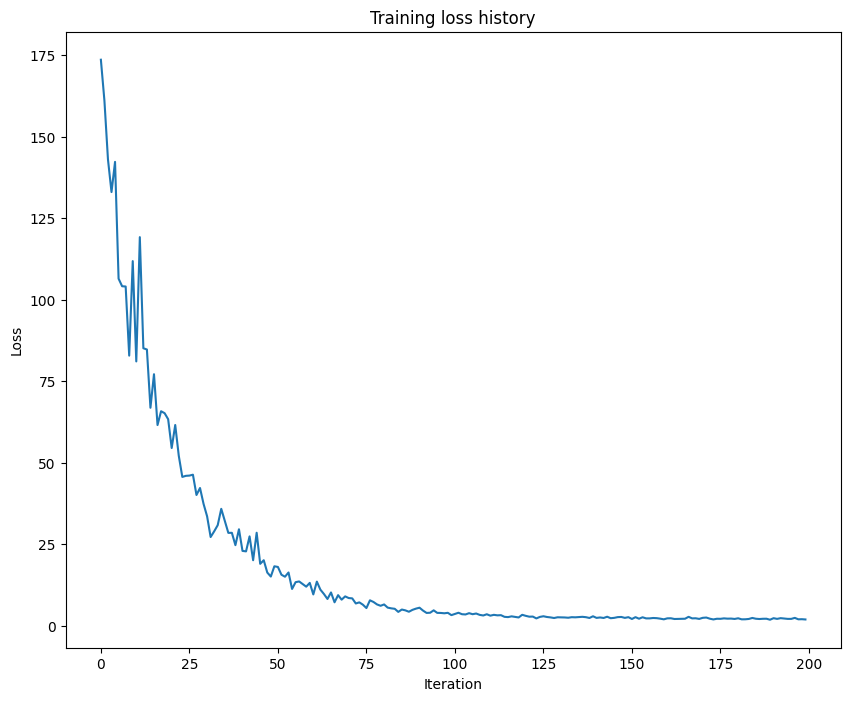

In [6]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_rnn_model = CaptioningRNN(
    cell_type='rnn',
    word_to_idx=small_data['word_to_idx'],
    input_dim=small_data['train_features'].shape[1],
    hidden_dim=512,
    wordvec_dim=256,
)

small_rnn_solver = CaptioningSolver(
    small_rnn_model, small_data,
    update_rule='adam',
    num_epochs=100,
    batch_size=25,
    optim_config={
     'learning_rate': 5e-3,
    },
    lr_decay=0.95,
    verbose=True, print_every=10,
)

small_rnn_solver.train()

# Plot the training losses.
plt.plot(small_rnn_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

Print final training loss. You should see a final loss of less than 0.1.

In [19]:
print('Final loss: ', small_rnn_solver.loss_history[-1])

Final loss:  1.9383921813964844


# RNN Sampling at Test Time
Unlike classification models, image captioning models behave very differently at training time vs. at test time. At training time, we have access to the ground-truth caption, so we feed ground-truth words as input to the RNN at each timestep. At test time, we sample from the distribution over the vocabulary at each timestep and feed the sample as input to the RNN at the next timestep.

In the file `CV/classifiers/rnn.py`, implement the `sample` method for test-time sampling. After doing so, run the following to sample from your overfitted model on both training and validation data. The samples on training data should be very good. The samples on validation data, however, probably won't make sense.

In [ ]:
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_rnn_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        img = image_from_url(url)
        # Skip missing URLs.
        if img is None: continue
        plt.imshow(img)
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Inline Question 1

In our current image captioning setup, our RNN language model produces a word at every timestep as its output. However, an alternate way to pose the problem is to train the network to operate over _characters_ (e.g. 'a', 'b', etc.) as opposed to words, so that at it every timestep, it receives the previous character as input and tries to predict the next character in the sequence. For example, the network might generate a caption like

'A', ' ', 'c', 'a', 't', ' ', 'o', 'n', ' ', 'a', ' ', 'b', 'e', 'd'

Can you describe one advantage of an image-captioning model that uses a character-level RNN? Can you also describe one disadvantage? HINT: there are several valid answers, but it might be useful to compare the parameter space of word-level and character-level models.

**Your Answer:**



If we use character-level RNN, we can implement the model with fewer parameter, since characters are far less than words. However, it might be hard to build the model with good performance since we should pass two steps with character-level RNN 1. make a reasonable words with characters 2. make a reasonable sentence with words

In [ ]:
import sys
!git clone https://github.com/vrama91/cider
sys.path.append('./cider')

%cd /content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/cider/pyciderevalcap/tokenizer/

import copy
import pickle
from collections import defaultdict
import numpy as np
import math
import os

def precook(s, n=4, out=False):
    """
    Takes a string as input and returns an object that can be given to
    either cook_refs or cook_test. This is optional: cook_refs and cook_test
    can take string arguments as well.
    :param s: string : sentence to be converted into ngrams
    :param n: int    : number of ngrams for which representation is calculated
    :return: term frequency vector for occuring ngrams
    """
    words = s.split()
    counts = defaultdict(int)
    for k in range(1,n+1):
        for i in range(len(words)-k+1):
            ngram = tuple(words[i:i+k])
            counts[ngram] += 1
    return counts

def cook_refs(refs, n=4): ## lhuang: oracle will call with "average"
    '''Takes a list of reference sentences for a single segment
    and returns an object that encapsulates everything that BLEU
    needs to know about them.
    :param refs: list of string : reference sentences for some image
    :param n: int : number of ngrams for which (ngram) representation is calculated
    :return: result (list of dict)
    '''
    return [precook(ref, n) for ref in refs]

def cook_test(test, n=4):
    '''Takes a test sentence and returns an object that
    encapsulates everything that BLEU needs to know about it.
    :param test: list of string : hypothesis sentence for some image
    :param n: int : number of ngrams for which (ngram) representation is calculated
    :return: result (dict)
    '''
    return precook(test, n, True)

class CiderScorer(object):
    """CIDEr scorer.
    """

    def copy(self):
        ''' copy the refs.'''
        new = CiderScorer(n=self.n)
        new.ctest = copy.copy(self.ctest)
        new.crefs = copy.copy(self.crefs)
        return new

    def __init__(self, test=None, refs=None, n=4, sigma=6.0):
        ''' singular instance '''
        self.n = n
        self.sigma = sigma
        self.crefs = []
        self.ctest = []
        self.document_frequency = defaultdict(float)
        self.cook_append(test, refs)
        self.ref_len = None

    def cook_append(self, test, refs):
        '''called by constructor and __iadd__ to avoid creating new instances.'''

        if refs is not None:
            self.crefs.append(cook_refs(refs))
            if test is not None:
                self.ctest.append(cook_test(test)) ## N.B.: -1
            else:
                self.ctest.append(None) # lens of crefs and ctest have to match

    def size(self):
        assert len(self.crefs) == len(self.ctest), "refs/test mismatch! %d<>%d" % (len(self.crefs), len(self.ctest))
        return len(self.crefs)

    def __iadd__(self, other):
        '''add an instance (e.g., from another sentence).'''

        if type(other) is tuple:
            ## avoid creating new CiderScorer instances
            self.cook_append(other[0], other[1])
        else:
            self.ctest.extend(other.ctest)
            self.crefs.extend(other.crefs)

        return self
    def compute_doc_freq(self):
        '''
        Compute term frequency for reference data.
        This will be used to compute idf (inverse document frequency later)
        The term frequency is stored in the object
        :return: None
        '''
        for refs in self.crefs:
            # refs, k ref captions of one image
            for ngram in set([ngram for ref in refs for (ngram,count) in ref.items()]):
                self.document_frequency[ngram] += 1
            # maxcounts[ngram] = max(maxcounts.get(ngram,0), count)

    def compute_cider(self, df_mode="corpus"):
        def counts2vec(cnts):
            """
            Function maps counts of ngram to vector of tfidf weights.
            The function returns vec, an array of dictionary that store mapping of n-gram and tf-idf weights.
            The n-th entry of array denotes length of n-grams.
            :param cnts:
            :return: vec (array of dict), norm (array of float), length (int)
            """
            vec = [defaultdict(float) for _ in range(self.n)]
            length = 0
            norm = [0.0 for _ in range(self.n)]
            for (ngram,term_freq) in cnts.items():
                # give word count 1 if it doesn't appear in reference corpus
                df = np.log(max(1.0, self.document_frequency[ngram]))
                # ngram index
                n = len(ngram)-1
                # tf (term_freq) * idf (precomputed idf) for n-grams
                vec[n][ngram] = float(term_freq)*(self.ref_len - df)
                # compute norm for the vector.  the norm will be used for
                # computing similarity
                norm[n] += pow(vec[n][ngram], 2)

                if n == 1:
                    length += term_freq
            norm = [np.sqrt(n) for n in norm]
            return vec, norm, length

        def sim(vec_hyp, vec_ref, norm_hyp, norm_ref, length_hyp, length_ref):
            '''
            Compute the cosine similarity of two vectors.
            :param vec_hyp: array of dictionary for vector corresponding to hypothesis
            :param vec_ref: array of dictionary for vector corresponding to reference
            :param norm_hyp: array of float for vector corresponding to hypothesis
            :param norm_ref: array of float for vector corresponding to reference
            :param length_hyp: int containing length of hypothesis
            :param length_ref: int containing length of reference
            :return: array of score for each n-grams cosine similarity
            '''
            delta = float(length_hyp - length_ref)
            # measure consine similarity
            val = np.array([0.0 for _ in range(self.n)])
            for n in range(self.n):
                # ngram
                for (ngram,count) in vec_hyp[n].items():
                    val[n] += vec_hyp[n][ngram] * vec_ref[n][ngram]

                if (norm_hyp[n] != 0) and (norm_ref[n] != 0):
                    val[n] /= (norm_hyp[n]*norm_ref[n])

                assert(not math.isnan(val[n]))
            return val

        # compute log reference length
        if df_mode == "corpus":
            self.ref_len = np.log(float(len(self.crefs)))
        elif df_mode == "coco-val-df":
            # if coco option selected, use length of coco-val set
            self.ref_len = np.log(float(40504))

        scores = []
        for test, refs in zip(self.ctest, self.crefs):
            # compute vector for test captions
            vec, norm, length = counts2vec(test)
            # compute vector for ref captions
            score = np.array([0.0 for _ in range(self.n)])
            for ref in refs:
                vec_ref, norm_ref, length_ref = counts2vec(ref)
                score += sim(vec, vec_ref, norm, norm_ref, length, length_ref)
            # change by vrama91 - mean of ngram scores, instead of sum
            score_avg = np.mean(score)
            # divide by number of references
            score_avg /= len(refs)
            # multiply score by 10
            score_avg *= 10.0
            # append score of an image to the score list
            scores.append(score_avg)
        return scores

    def compute_score(self, df_mode, option=None, verbose=0):
        # compute idf
        if df_mode == "corpus":
            self.compute_doc_freq()
            # assert to check document frequency
            assert(len(self.ctest) >= max(self.document_frequency.values()))
            # import json for now and write the corresponding files
        else:
            self.document_frequency = pickle.load(open(os.path.join('data', df_mode + '.p'),'r'))
        # compute cider score
        score = self.compute_cider(df_mode)
        # debug
        # print score
        return np.mean(np.array(score)), np.array(score)

import os
import pdb # python debugger
import sys
import subprocess
import re
import tempfile
import itertools

# path to the stanford corenlp jar
STANFORD_CORENLP_3_4_1_JAR = 'stanford-corenlp-3.4.1.jar'

# punctuations to be removed from the sentences
PUNCTUATIONS = ["''", "'", "``", "`", "-LRB-", "-RRB-", "-LCB-", "-RCB-", \
        ".", "?", "!", ",", ":", "-", "--", "...", ";"]

file_path = "/content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/cider/pyciderevalcap/tokenizer/"

class PTBTokenizer:
    """Python wrapper of Stanford PTBTokenizer"""
    def __init__(self, _source='gts'):
        self.source = _source

    def tokenize(self, captions_for_image):
        cmd = ['java', '-cp', STANFORD_CORENLP_3_4_1_JAR, \
                'edu.stanford.nlp.process.PTBTokenizer', \
                '-preserveLines', '-lowerCase']

        # ======================================================
        # prepare data for PTB Tokenizer
        # ======================================================

        if self.source == 'gts':
            image_id = [k for k, v in captions_for_image.items() for _ in range(len(v))]
            sentences = '\n'.join([c['caption'].replace('\n', ' ') for k, v in captions_for_image.items() for c in v])
            final_tokenized_captions_for_image = {}

        elif self.source == 'res':
            index = [i for i, v in enumerate(captions_for_image)]
            image_id = [v["image_id"] for v in captions_for_image]
            sentences = '\n'.join(v["caption"].replace('\n', ' ') for v in captions_for_image )
            final_tokenized_captions_for_index = []

        # ======================================================
        # save sentences to temporary file
        # ======================================================
        path_to_jar_dirname=os.path.dirname(file_path)
        tmp_file = tempfile.NamedTemporaryFile(delete=False, dir=path_to_jar_dirname)
        tmp_file.write(sentences.encode("utf-8"))
        tmp_file.close()

        # ======================================================
        # tokenize sentence
        # ======================================================
        cmd.append(os.path.basename(tmp_file.name))
        p_tokenizer = subprocess.Popen(cmd, cwd=path_to_jar_dirname, \
                stdout=subprocess.PIPE)
        token_lines = p_tokenizer.communicate(input=sentences.rstrip())[0]
        lines = token_lines.decode("utf-8").split('\n')
        # remove temp file
        os.remove(tmp_file.name)

        # ======================================================
        # create dictionary for tokenized captions
        # ======================================================
        if self.source == 'gts':
            for k, line in zip(image_id, lines):
                if not k in final_tokenized_captions_for_image:
                    final_tokenized_captions_for_image[k] = []
                tokenized_caption = ' '.join([w for w in line.rstrip().split(' ') \
                        if w not in PUNCTUATIONS])
                final_tokenized_captions_for_image[k].append(tokenized_caption)

            return final_tokenized_captions_for_image

        elif self.source == 'res':
            for k, img, line in zip(index, image_id, lines):
                tokenized_caption = ' '.join([w for w in line.rstrip().split(' ') \
                        if w not in PUNCTUATIONS])
                final_tokenized_captions_for_index.append({'image_id': img, 'caption': [tokenized_caption]})

            return final_tokenized_captions_for_index

# from cider.cider_scorer import CiderScorer
# from tokenizer.ptbtokenizer import PTBTokenizer

class Cider:
    def __init__(self, n=4, df="corpus"):
        self._n = n
        self._df = df

    def compute_score(self, gts, res):

        cider_scorer = CiderScorer(n=self._n)

        for res_id in res:

            hypo = res_id['caption']
            ref = gts[res_id['image_id']]

            # Sanity check.
            assert(type(hypo) is list)
            assert(len(hypo) == 1)
            assert(type(ref) is list)
            assert(len(ref) > 0)
            cider_scorer += (hypo[0], ref)

        (score, scores) = cider_scorer.compute_score(self._df)

        return score, scores

    def method(self):
        return "CIDEr"

class CIDErEvalCap:
    def __init__(self, gts, res, df):
        tokenizer = PTBTokenizer('gts')
        _gts = tokenizer.tokenize(gts)
        tokenizer = PTBTokenizer('res')
        _res = tokenizer.tokenize(res)
        self.gts = _gts
        self.res = _res
        self.df = df

    def evaluate(self):
        # =================================================
        # Set up scorers
        # =================================================

        scorers = [
            (Cider(df=self.df), "CIDEr")
        ]

        metric_scores = {}
        metric_score = {}
        for scorer, method in scorers:
            score, scores = scorer.compute_score(self.gts, self.res)
            metric_score[method] = score
            metric_scores[method] = list(scores)
        return metric_score, metric_scores

fatal: destination path 'cider' already exists and is not an empty directory.
/content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/cider/pyciderevalcap/tokenizer


In [ ]:
train_feat = data["train_features"][data["train_image_idxs"]]
gts_cap_train = decode_captions(data["train_captions"], data['idx_to_word'])
res_cap_train = decode_captions(small_rnn_model.sample(train_feat), data['idx_to_word'])
gts_train = defaultdict(list)
res_train = []
for i in range(len(data['train_captions'])):
  gts_train[str(data['train_image_idxs'][i])].append({"caption" : gts_cap_train[i]})
  re_curr = dict()
  re_curr["image_id"] = str(data['train_image_idxs'][i])
  re_curr["caption"] = res_cap_train[i]
  res_train.append(re_curr)

df_mode = "corpus"
scorer_train = CIDErEvalCap(gts_train, res_train, df_mode)
score_train, scores_train = scorer_train.evaluate()
print(f"train CIDEr : {100 * score_train['CIDEr']}")

val_feat = data["val_features"][data["val_image_idxs"]]
gts_cap_val = decode_captions(data["val_captions"], data['idx_to_word'])
res_cap_val = decode_captions(small_rnn_model.sample(val_feat), data['idx_to_word'])
gts_val = defaultdict(list)
res_val = []
for i in range(len(data['val_captions'])):
  gts_val[str(data['val_image_idxs'][i])].append({"caption" : gts_cap_val[i]})
  re_curr = dict()
  re_curr["image_id"] = str(data['val_image_idxs'][i])
  re_curr["caption"] = res_cap_val[i]
  res_val.append(re_curr)

df_mode = "corpus"
scorer_val = CIDErEvalCap(gts_val, res_val, df_mode)
score_val, scores_val = scorer_val.evaluate()
print(f"val CIDEr : {100 * score_val['CIDEr']}")

train CIDEr : 7.235840038294247
val CIDEr : 6.869791869230115


In [ ]:
from torchvision.transforms.functional import resize
import torch
a = torch.randn(5, 1, 1, 2)
print(a.shape)
resize(a, [10, 10])

torch.Size([5, 1, 1, 2])


tensor([[[[-1.5521e-01, -1.5521e-01, -1.5521e-01, -3.6816e-02,  8.1578e-02,
            1.9997e-01,  3.1836e-01,  4.3676e-01,  4.3676e-01,  4.3676e-01],
          [-1.5521e-01, -1.5521e-01, -1.5521e-01, -3.6816e-02,  8.1578e-02,
            1.9997e-01,  3.1836e-01,  4.3676e-01,  4.3676e-01,  4.3676e-01],
          [-1.5521e-01, -1.5521e-01, -1.5521e-01, -3.6816e-02,  8.1578e-02,
            1.9997e-01,  3.1836e-01,  4.3676e-01,  4.3676e-01,  4.3676e-01],
          [-1.5521e-01, -1.5521e-01, -1.5521e-01, -3.6816e-02,  8.1578e-02,
            1.9997e-01,  3.1836e-01,  4.3676e-01,  4.3676e-01,  4.3676e-01],
          [-1.5521e-01, -1.5521e-01, -1.5521e-01, -3.6816e-02,  8.1578e-02,
            1.9997e-01,  3.1836e-01,  4.3676e-01,  4.3676e-01,  4.3676e-01],
          [-1.5521e-01, -1.5521e-01, -1.5521e-01, -3.6816e-02,  8.1578e-02,
            1.9997e-01,  3.1836e-01,  4.3676e-01,  4.3676e-01,  4.3676e-01],
          [-1.5521e-01, -1.5521e-01, -1.5521e-01, -3.6816e-02,  8.1578e-02,
      